# Set up and basics

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, LSTMCell, RNN, Reshape
from keras.callbacks import EarlyStopping
from keras import initializers, Model
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
# import plotly.offline as py
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)
%matplotlib inline

Import test data

In [2]:
data = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data_0401(6hrs).csv')
data.columns = ['scrape_time','lastUpdateId','bp_1','bz_1','bp_2','bz_2','bp_3','bz_3','bp_4','bz_4','bp_5','bz_5','bp_6','bz_6','bp_7','bz_7','bp_8','bz_8','bp_9','bz_9','bp_10','bz_10','bp_11','bz_11','bp_12','bz_12','bp_13','bz_13','bp_14','bz_14','bp_15','bz_15','bp_16','bz_16','bp_17','bz_17','bp_18','bz_18','bp_19','bz_19','bp_20','bz_20','ap_1','az_1','ap_2','az_2','ap_3','az_3','ap_4','az_4','ap_5','az_5','ap_6','az_6','ap_7','az_7','ap_8','az_8','ap_9','az_9','ap_10','az_10','ap_11','az_11','ap_12','az_12','ap_13','az_13','ap_14','az_14','ap_15','az_15','ap_16','az_16','ap_17','az_17','ap_18','az_18','ap_19','az_19','ap_20','az_20']
data.drop(['lastUpdateId'], axis=1, inplace= True)

In [3]:
## Drop scrape_time and create scrape_time_diff

data['scrape_time_interval'] = pd.to_datetime(data['scrape_time']).diff().dt.total_seconds()
data.drop(['scrape_time'], axis=1, inplace= True)

In [4]:
##################### Basic Feature Creation ##################
### Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

#### Spread
data['spread'] = ((data['ap_1']/data['bp_1']) - 1)

### Log price
def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

### Log returns
data['log_returns'] = data.log_price.diff()

### Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

### Future volatility
data['volatility_t+1'] = data['realized_volatility'].shift(-1)

### Bid quantities
data['bid depth'] = data[['bz_1', 'bz_2', 'bz_3','bz_4', 'bz_5', 'bz_6','bz_7', 'bz_8', 'bz_9','bz_10',
                         'bz_11', 'bz_12', 'bz_13','bz_14', 'bz_15', 'bz_16','bz_17', 'bz_18', 'bz_19','bz_20']].sum(axis=1)


#sum of all bid quantities
data['ask depth'] = data[['az_1', 'az_2', 'az_3','az_4', 'az_5', 'az_6','az_7', 'az_8', 'az_9','az_10',
                         'az_11', 'az_12', 'az_13','az_14', 'az_15', 'az_16','az_17', 'az_18', 'az_19','az_20']].sum(axis=1)


## Bid-ask Imbalance
data['bid_ask_imbalance'] = (data['bid depth'] - data['ask depth']) / (data['bid depth'] + data['ask depth'])

In [5]:
df = data.copy()

In [6]:
data.drop(['bp_1','bp_2','bp_3','bp_4','bp_5','bp_6','bp_7','bp_8','bp_9','bp_10','bp_11','bp_12','bp_13','bp_14','bp_15','bp_16','bp_17','bp_18','bp_19','bp_20',
          'bz_1','bz_2','bz_3','bz_4','bz_5','bz_6','bz_7','bz_8','bz_9','bz_10','bz_11','bz_12','bz_13','bz_14','bz_15','bz_16','bz_17','bz_18','bz_19','bz_20',
          'ap_1','ap_2','ap_3','ap_4','ap_5','ap_6','ap_7','ap_8','ap_9','ap_10','ap_11','ap_12','ap_13','ap_14','ap_15','ap_16','ap_17','ap_18','ap_19','ap_20',
            'az_1','az_2','az_3','az_4','az_5','az_6','az_7','az_8','az_9','az_10','az_11','az_12','az_13','az_14','az_15','az_16','az_17','az_18','az_19','az_20'],axis=1, inplace=True)
          

In [8]:
data = data.iloc[3:-1,:].reset_index()
data.drop(['index'], axis=1, inplace= True)

df = df.iloc[3:-1,:].reset_index()
df.drop(['index'], axis=1, inplace= True)

In [9]:
data.shape, df.shape

((9165, 10), (9165, 90))

# Feature Adding

In [10]:
# ######### List of features consider to add ############
# ######### SelectKBest Method #########################
# 1. ob_weighted_price
# 2. EMA
# 3. SMA
# 4. TWAP
# 5. price_level
# 6. WAP
# 7. log_price
# 8. Volatility_Indicators
# 9. order_book_slope
# 10. total_volume
# #################################################

In [11]:
# 1. ob_weighted_price
def weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes):
    total_size = sum(bid_sizes) + sum(ask_sizes)
    if total_size == 0:
        return None
    bid_sum = sum([bid_prices[i] * bid_sizes[i] for i in range(len(bid_prices))])
    ask_sum = sum([ask_prices[i] * ask_sizes[i] for i in range(len(ask_prices))])
    return (bid_sum + ask_sum) / total_size

ob_weighted_price_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    ob_weighted_price = weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes)
    ob_weighted_price_list.append(ob_weighted_price)
    
data['ob_weighted_price'] = ob_weighted_price_list

In [12]:
# 2. EMA
# 3. SMA

SMA_list = []
EMA_list = []


for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    closing_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    
    # Calculate a 12-period simple moving average
    periods = 12
    sma = np.mean(closing_prices[-periods:])
    SMA_list.append(sma)
    
    # Create a pandas DataFrame with the closing prices
    df_ema = pd.DataFrame({"Close": closing_prices})
    ema = df_ema["Close"].ewm(span=periods, adjust=False).mean().iloc[-1]
    EMA_list.append(ema)


data['SMA'] = SMA_list
data['EMA'] = EMA_list

In [13]:
# 4. TWAP


TWAP_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    total_bid_volume = sum(bid_sizes)
    total_ask_volume = sum(ask_sizes)

    # Initialize variables for TWAP calculation
    twap_numerator = 0
    twap_denominator = 0
    time_interval = 60  # in seconds
    total_time = time_interval * len(bid_prices)

    # Calculate TWAP
    for i in range(len(bid_prices)):
        mid_price = (bid_prices[i] + ask_prices[i]) / 2
        volume = min(bid_sizes[i], ask_sizes[i])
        twap_numerator += mid_price * volume * time_interval
        twap_denominator += volume * time_interval

    TWAP = twap_numerator / twap_denominator
    TWAP_list.append(TWAP)
    
data['TWAP'] = TWAP_list

In [14]:
# 5. price_level
data['price_level'] = (df['bp_1'] + df['ap_1'])/2

In [15]:
# 6. WAP
# DONE

# 7. log_price
# DONE

In [16]:
# 8. Volatility_Indicators

Volatility_Indicators_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    
    # Calculate price returns as the percentage change between consecutive prices
    price_returns = np.diff(bid_prices) / bid_prices[:-1]
    
    # Calculate the 5-minute rolling standard deviation of price returns
    rolling_std = np.std(price_returns[-20:]) 
    
    Volatility_Indicators_list.append(rolling_std)
    
data['Volatility_Indicators'] = Volatility_Indicators_list 

In [17]:
# 9. order_book_slope

order_book_slope_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    # Perform linear regression on the bid prices
    bid_model = LinearRegression().fit(np.arange(len(bid_prices)).reshape(-1, 1), bid_prices)

    # Get the bid slope coefficient
    bid_slope = bid_model.coef_[0]

    # Perform linear regression on the ask prices
    ask_model = LinearRegression().fit(np.arange(len(ask_prices)).reshape(-1, 1), ask_prices)

    # Get the ask slope coefficient
    ask_slope = ask_model.coef_[0]

    # Calculate the average slope as the order book slope
    order_book_slope = (bid_slope + ask_slope) / 2
    order_book_slope_list.append(order_book_slope)


data['order_book_slope'] = order_book_slope_list

In [18]:
# 10. total_volume
data['total_volume'] = data['bid depth'] + data['ask depth']

# Feature Selection 2.0

In [19]:
# Splitting the data into features and target variable
X = data.drop(['realized_volatility','volatility_t+1'], axis=1)
y = data['volatility_t+1']

## SelectKBest Method

In [20]:
# assuming X and y are your feature matrix and target variable
f_values, p_values = f_regression(X, y)

# sort the p_values in ascending order
p_values_sorted = np.argsort(p_values)

# select the top 5 features based on p_values
top_features_5 = X.columns[p_values_sorted][:5]

# select the top 5 features based on p_values
top_features_10 = X.columns[p_values_sorted][:10]

print(f"The top 5 features selected using f_regression are: {top_features_5}")
print('')
print(f"The top 10 features selected using f_regression are: {top_features_10}")

The top 5 features selected using f_regression are: Index(['ob_weighted_price', 'EMA', 'SMA', 'TWAP', 'price_level'], dtype='object')

The top 10 features selected using f_regression are: Index(['ob_weighted_price', 'EMA', 'SMA', 'TWAP', 'price_level', 'WAP',
       'log_price', 'Volatility_Indicators', 'order_book_slope',
       'total_volume'],
      dtype='object')


In [21]:
'ob_weighted_price', 'EMA', 'SMA', 'TWAP', 'price_level'

('ob_weighted_price', 'EMA', 'SMA', 'TWAP', 'price_level')

In [22]:
X_SKB_5 = X.drop(['WAP','log_price', 'Volatility_Indicators', 'order_book_slope',
       'total_volume', 'bid depth', 'bid_ask_imbalance', 'spread',
       'scrape_time_interval', 'log_returns', 'ask depth'], axis=1)

X_SKB_10 = X.drop(['bid depth', 'bid_ask_imbalance', 'spread',
                   'scrape_time_interval', 'log_returns', 'ask depth'], axis=1)

# LSTM

In [23]:
y = np.expand_dims(y.values, 1)

In [24]:
scaler = MinMaxScaler().fit(X_SKB_5)
X_scaled = scaler.transform(X_SKB_5)
X_scaled.shape

(9165, 5)

In [26]:
def convert2matrix(X_arr,Y_arr, look_back=1):
    X, Y =[], []
    #iterating thorough the data with window as look back
    for i in range(len(X_arr)-look_back):
        d=i+look_back 
        # extracting the X as features and target of n days and Y as   target at (n+1)th day
        X.append(np.hstack((X_arr[i:d],Y_arr[i:d])))
        Y.append(Y_arr[d])
    return np.array(X), np.array(Y)

In [27]:
# transformer = Normalizer().fit(X)
# n_X = transformer.transform(X)
# n_X.shape
X_new, y_new = convert2matrix(X_scaled, y, 10)
print(X_new.shape, y_new.shape)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, shuffle=False)

(9155, 10, 6) (9155, 1)


In [28]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_new.shape[1], X_new.shape[2])))
# model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
# model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1))

In [29]:
model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mape'])
history = model.fit(X_train, y_train, epochs=500, batch_size=8, shuffle=True,
                    validation_split=0.2,
                    callbacks = 
                    [EarlyStopping(patience=50, verbose=1)])

Epoch 1/500


2023-04-04 15:50:58.833013: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


641/641 [==============================] - 9s 11ms/step - loss: 3.4147e-04 - mape: 13338.7246 - val_loss: 5.4836e-08 - val_mape: 451.6366
Epoch 2/500
641/641 [==============================] - 7s 11ms/step - loss: 7.5570e-07 - mape: 1859.7881 - val_loss: 1.3546e-06 - val_mape: 3093.2205
Epoch 3/500
641/641 [==============================] - 8s 12ms/step - loss: 1.1262e-06 - mape: 2238.6792 - val_loss: 1.2007e-06 - val_mape: 2941.4700
Epoch 4/500
641/641 [==============================] - 7s 12ms/step - loss: 5.9368e-06 - mape: 5018.5122 - val_loss: 4.2898e-07 - val_mape: 1715.1757
Epoch 5/500
641/641 [==============================] - 7s 11ms/step - loss: 5.6710e-06 - mape: 4821.4062 - val_loss: 4.9729e-07 - val_mape: 1748.5646
Epoch 6/500
641/641 [==============================] - 8s 12ms/step - loss: 7.5847e-06 - mape: 5459.1421 - val_loss: 1.2413e-06 - val_mape: 3016.1338
Epoch 7/500
641/641 [==============================] - 8s 13ms/step - loss: 7.4773e-06 - mape: 4381.7446 - val_l

641/641 [==============================] - 7s 11ms/step - loss: 8.1123e-10 - mape: 63.1899 - val_loss: 8.8944e-11 - val_mape: 25.1035
Epoch 57/500
641/641 [==============================] - 7s 11ms/step - loss: 8.4491e-10 - mape: 62.4893 - val_loss: 3.2463e-10 - val_mape: 48.8029
Epoch 58/500
641/641 [==============================] - 7s 11ms/step - loss: 7.8036e-10 - mape: 61.2232 - val_loss: 5.1545e-11 - val_mape: 18.9532
Epoch 59/500
641/641 [==============================] - 7s 10ms/step - loss: 9.5396e-10 - mape: 68.1464 - val_loss: 2.7133e-10 - val_mape: 44.5837
Epoch 60/500
641/641 [==============================] - 7s 11ms/step - loss: 8.5705e-10 - mape: 65.0305 - val_loss: 6.7307e-10 - val_mape: 70.0907
Epoch 61/500
641/641 [==============================] - 7s 10ms/step - loss: 8.1531e-10 - mape: 63.3655 - val_loss: 2.7542e-12 - val_mape: 3.2639
Epoch 62/500
641/641 [==============================] - 7s 11ms/step - loss: 8.7034e-10 - mape: 66.0673 - val_loss: 4.5888e-10 - val

Epoch 112/500
641/641 [==============================] - 7s 10ms/step - loss: 8.8979e-10 - mape: 67.9440 - val_loss: 3.3970e-10 - val_mape: 49.4152
Epoch 113/500
641/641 [==============================] - 7s 10ms/step - loss: 8.9842e-10 - mape: 64.2021 - val_loss: 2.7807e-10 - val_mape: 44.4806
Epoch 114/500
641/641 [==============================] - 7s 10ms/step - loss: 7.6789e-10 - mape: 61.8994 - val_loss: 6.7353e-10 - val_mape: 70.0550
Epoch 115/500
641/641 [==============================] - 7s 10ms/step - loss: 8.8418e-10 - mape: 65.4200 - val_loss: 1.8328e-10 - val_mape: 36.3634
Epoch 116/500
641/641 [==============================] - 7s 11ms/step - loss: 8.4174e-10 - mape: 63.4114 - val_loss: 3.7970e-12 - val_mape: 3.9936
Epoch 117/500
641/641 [==============================] - 7s 10ms/step - loss: 9.6323e-10 - mape: 69.8991 - val_loss: 1.3511e-10 - val_mape: 31.1337
Epoch 118/500
641/641 [==============================] - 7s 10ms/step - loss: 9.1379e-10 - mape: 66.0706 - val_lo

BaseLine

In [30]:
from sklearn.metrics import mean_absolute_error
pred = model.predict(X_test)
pred.shape

86/86 [==============================] - 1s 6ms/step


(2747, 1)

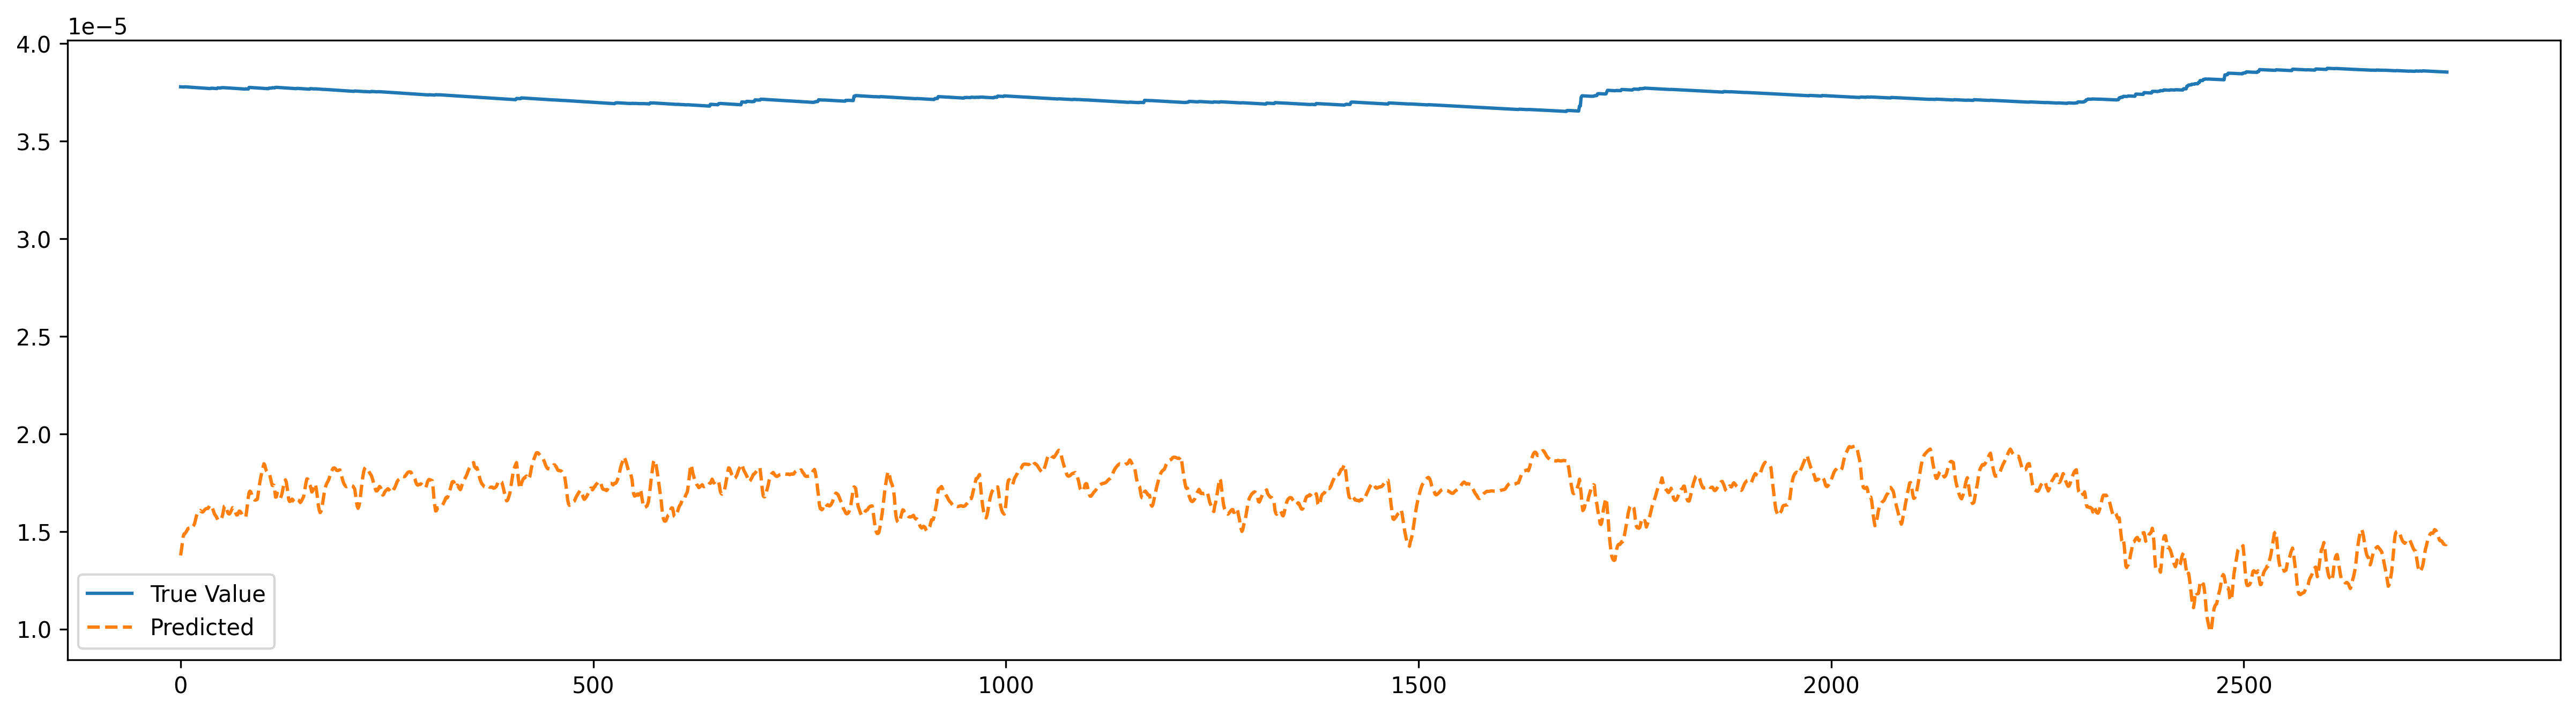

In [31]:
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [32]:
tb_mae = np.mean(np.abs(y_test - pred))
tb_mae

2.0708894622336463e-05

201/201 [==============================] - 1s 7ms/step


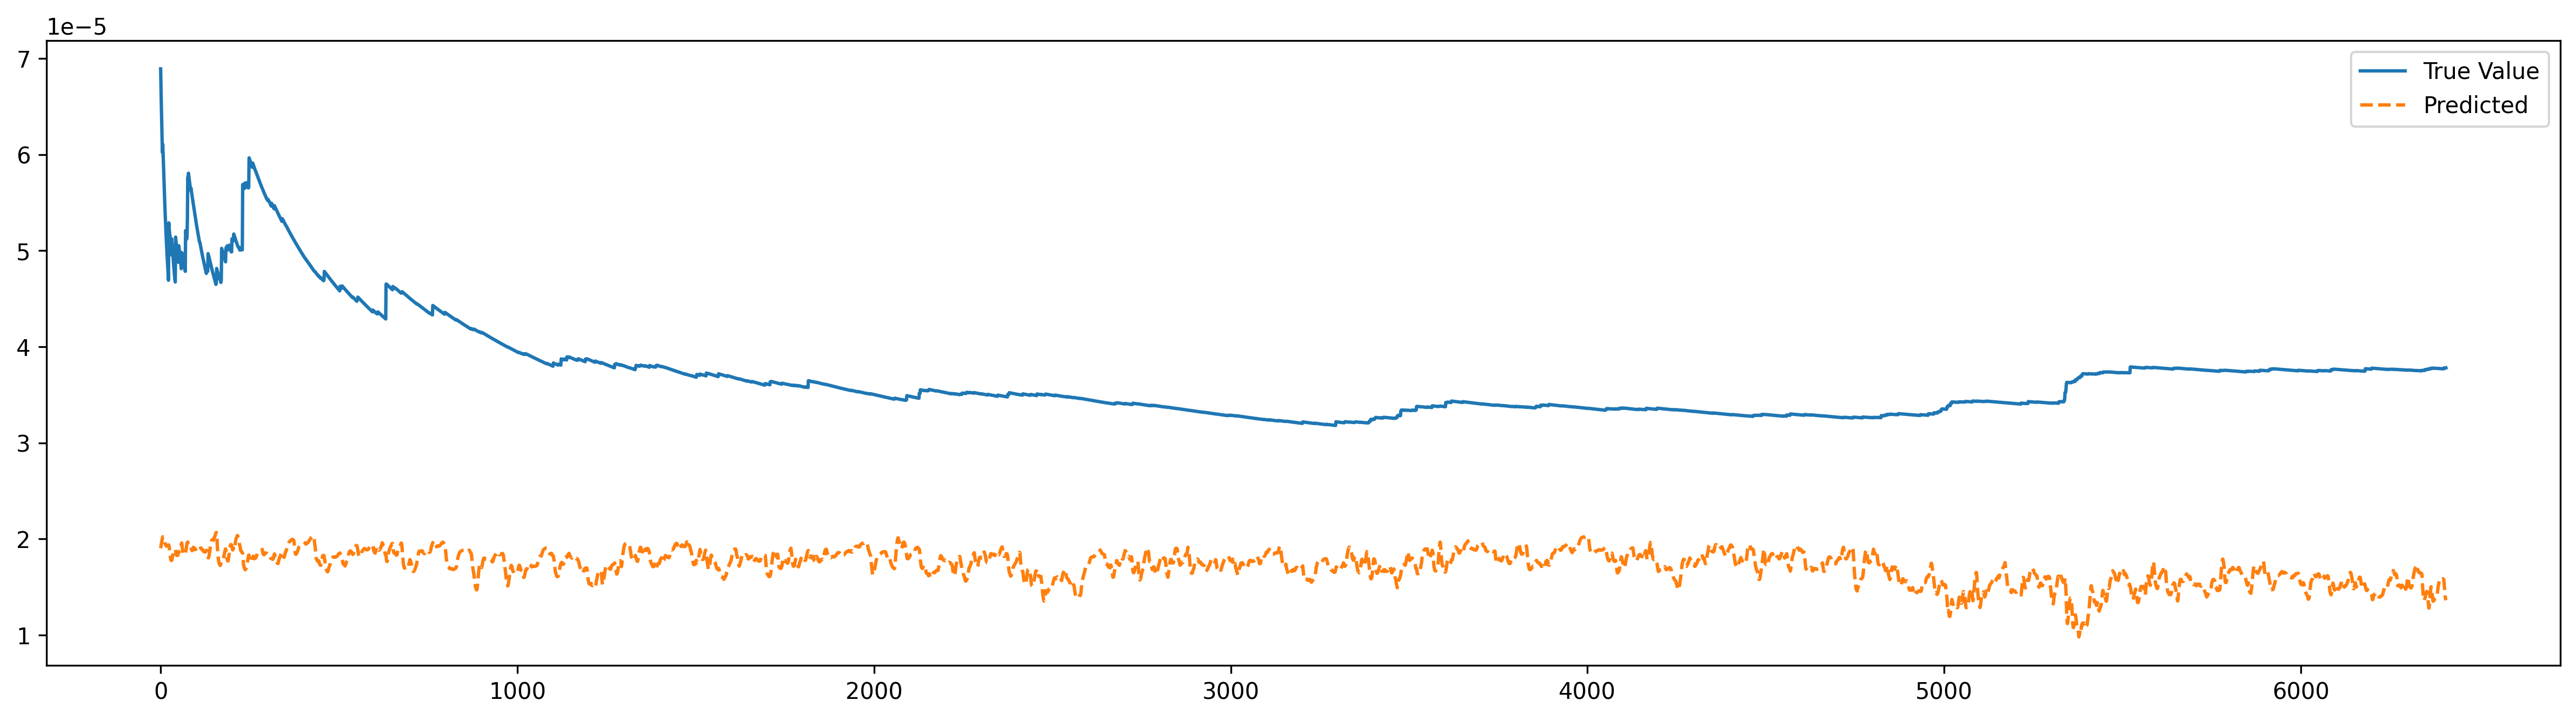

In [33]:
pred = model.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [34]:
model.evaluate(X_test, y_test), model.evaluate(X_train, y_train)

201/201 [==============================] - 1s 6ms/step - loss: 4.1873e-10 - mape: 52.8844


([4.3311995656658553e-10, 55.40153503417969],
 [4.1873407519155137e-10, 52.88440704345703])

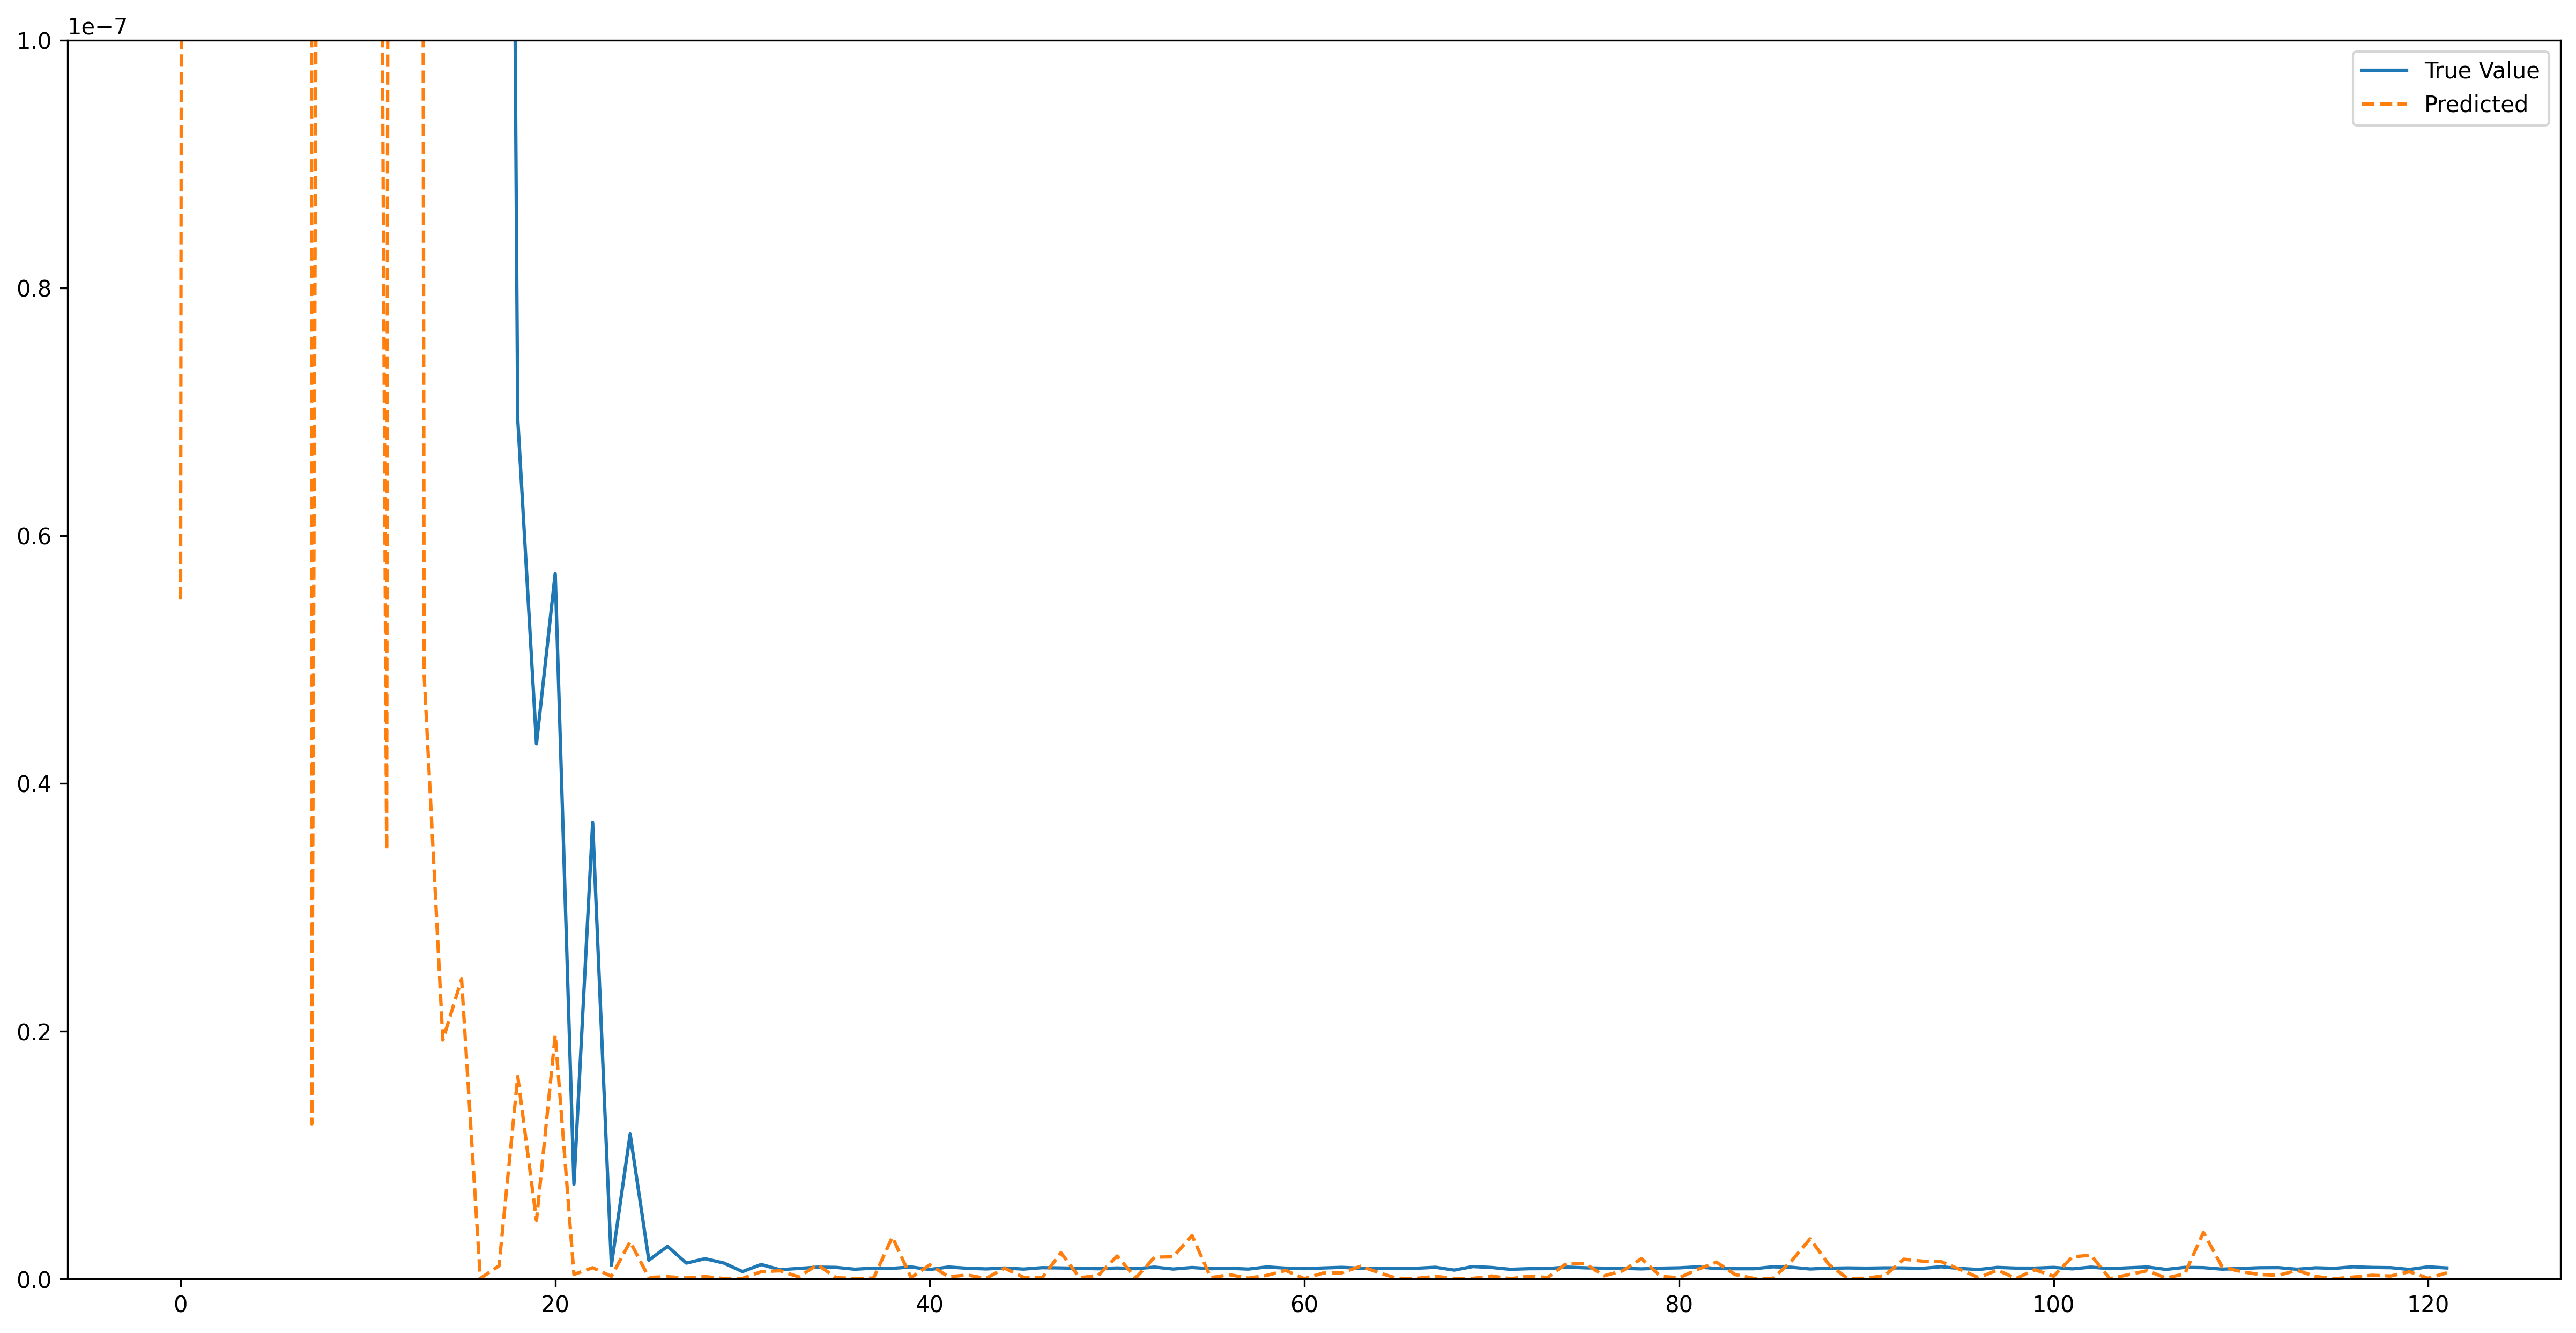

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(20,10),dpi=300)
plt.plot(loss,label='True Value')
plt.plot(val_loss,linestyle='--', label = 'Predicted')
plt.legend()
plt.ylim(0, 0.0000001)
plt.show()